<a href="https://colab.research.google.com/github/maragraziani/interpretAI_DigiPath/blob/main/hands-on-session-1/feature_attribution_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Hands-on Session 1</center>
## <center> Feature Attribution: Gradient-weighted Class Activation Mapping (Grad-CAM)</center>

**Presented by:**
- Mara Graziani
    - PhD student at Hes-so Valais & University of Geneva
    - mara.graziani@hevs.ch  
    
#### Content

* [Introduction & Motivation](#intro)
* [Installation & Data](#Section0)
* [(1) Grad-CAM for object classification](#Section1)
* [(2) Grad-CAM for breast cancer pathology](#Section2)

#### Take-away messages

* Easy-to-apply, intuitive, computationally fast
* Optimal tool for initial debugging and to verify wrong behaviors
* Limited to visual assessment, risk of confirmation bias

<div id="Intro"></div> 

## Introduction & Motivation: Why and when should we use Grad-CAM?

You will be guiding in this first notebook to generate Grad-CAM visualizations of a 2D Convolutional Neural Network. 

Grad-CAM is a post-hoc interpretability method that generates a localization map by visualizing the contribution of each feature map to the network prediction. The cascade of gradients is taken into account to weight the feature maps contributions.

Why should we use Grad-CAM?

- It is easy-to apply, off-the-shelf
- It is model agnostic
- It preserves model performance

When should we use Grad-CAM?

- If you already have a trained deep learning model with good performance
- If you want to debug your model to verify expected behavior
- If you want to evaluate the network attention to the features for one class, against another class

**References:**

1. [B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep 
Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).](http://cnnlocalization.csail.mit.edu/) Zhou et al., CVPR, 2016.
2.  [Selvaraju, Ramprasaath R., et al. "Grad-cam: Visual explanations from deep networks via gradient-based localization." Proceedings of the IEEE international conference on computer vision. 2017.](http://gradcam.cloudcv.org/) Selvaraju et al., ICCV, 2017.

<div id="Section0"></div> 

## Installation and Data 

- Running on **Colab**: this tutorial requires a GPU. Colab allows you to use a K80 GPU for 12h. Please do the following steps:
    - Open the tab *Runtime*
    - Click on *Change Runtime Type*
    - Set the hardware to *GPU* and *Save*


- This demo uses the Camelyon dataset. To facilitate research on these challenging data, a subset of images with fixed splits called **PatchCamelyon** (PCam) was released on Kaggle for a benchmarking challenge.  You can add the full PCam dataset by selecting the option "create a shortcut to my Drive" [at this link](https://drive.google.com/drive/folders/1gHou49cA1s5vua2V5L98Lt8TiWA3FrKB?usp=sharing).

<figure class="image">
  <img src="https://raw.githubusercontent.com/basveeling/pcam/master/pcam.jpg" width="800">
</figure>
Example images from [PCam](https://github.com/basveeling/pcam).

**References:**

3. B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962
4. Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

In [1]:
import sys
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.metrics import roc_curve, auc
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.disable_eager_execution()
tf.keras.backend.clear_session()

BATCH_SIZE = 32
SEED=0
np.random.seed(SEED)
data_folder='/content/drive/MyDrive/CNNinterpret'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<div id="Section1"></div> 

## 1) Grad-CAM for object classification
This code contains the main function to implement Grad-CAM.

### Core idea: Class Activation Mapping
The core idea behind Grad-CAM is that of Class Activation Mapping introduced by [Zhou et al. (2016)](http://cnnlocalization.csail.mit.edu/), as illustrated in the figure below.  

<figure class="image">
  <img src="http://cnnlocalization.csail.mit.edu/framework.jpg" width="800">
</figure>

- The output of the convolutional layers are multiple feature maps of dimensions w x h x c.
- Global Average Pooling (GAP) takes the spatial average (on w and h) of each feature map to obtain a vector of dimension c.
- This vector is **weighted** by the last layer vector of weights W to determine the contributions to the classification layer.
- The heatmap is obtained by the weighted sum of each feature map, where W is used as weight.

### Extension to Gradient-weighted CAMs (Grad-CAM)
Grad-CAM generalizes CAM as it generates visual explanations by directly taking into account the cascade of gradients. 
This approach by-passes the need of a GAP operation and makes this method applicable to a wide variety of  models and applications, including image captioning and query answering. 
These two methods were shown to be equivalent up to anormalization constant that is proportional to the number of pixels in the feature maps [Selvaraju et al., 2017](http://gradcam.cloudcv.org/).

<figure class="image">
  <img src="http://gradcam.cloudcv.org/static/images/network.png" width="800">
</figure>

- The **weighting** vector is obtained by the propagation of the gradients. 
- The gradient for every feature map is used as a weight.
- A ReLU activation function is used to only retain positive activations.


In [3]:
# Loading the model pretrained on ImageNet ~ 4seconds
vgg_model=tf.keras.applications.VGG16(weights='imagenet')

In [4]:
def grad_cam(input_model, image, layer_name,H=224,W=224):
    """
    GradCAM method for visualizing input saliency.
    Inputs:
    input_model: keras instance of a deep learning model
    image: input image for which we want to obtain the heatmap
    layer_name: identifier of the last convolutional layer in the network
    H: image height
    W: image width

    Returns:
    A 2-D array of values between the [0,1] range corresponding to the 
    normalized Grad-CAM heatmap values.
    """
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

    predicted_class = np.argmax(input_model.predict(image))
    y_c = input_model.output[0, predicted_class]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    cam = np.maximum(cam, 0) 
    cam = cv2.resize(cam, (H, W))
    cam = cam / cam.max()
    return cam

--2021-04-20 13:45:13--  https://zenodo.org/record/4669282/files/elephant.jpg
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1167136 (1.1M) [image/jpeg]
Saving to: ‘elephant.jpg’

elephant.jpg        100%[===================>]   1.11M  1.51MB/s    in 0.7s    

2021-04-20 13:45:15 (1.51 MB/s) - ‘elephant.jpg’ saved [1167136/1167136]



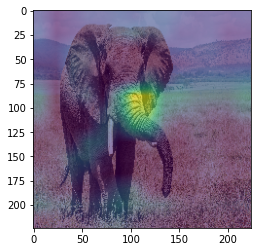

In [ ]:
# ELEPHANT
!wget https://zenodo.org/record/4669282/files/elephant.jpg
!mv elephant.jpg /content/drive/MyDrive/CNNinterpret/
img = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/CNNinterpret/elephant.jpg', target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)
hmap=grad_cam(vgg_model, x, 'block5_conv3', H=224, W=224)
plt.imshow(img)
plt.imshow(hmap, alpha=0.6)

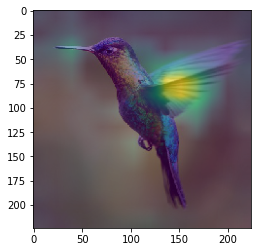

In [ ]:
# HUMMINGBIRD
!wget https://zenodo.org/record/4669282/files/hummingbird.jpg
!mv hummingbird.jpg /content/drive/MyDrive/CNNinterpret/
img = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/CNNinterpret/hummingbird.jpg', target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)
hmap=grad_cam(vgg_model, x, 'block5_conv3', H=224, W=224)
plt.imshow(img)
plt.imshow(hmap, alpha=0.6)

<div id="Section2"></div> 

## 2) Grad-CAM for histopathology




In [40]:
# Adapting the VGG model to the histopathology task ~ 2 minutes
!wget https://zenodo.org/record/4669282/files/weights.h5
!mv weights.h5 /content/drive/MyDrive/CNNinterpret/
predictions=tf.keras.layers.Dense(1,activation='sigmoid')(vgg_model.layers[-2].output)
vgg_histo_model = tf.keras.Model(vgg_model.input, predictions)
vgg_histo_model.load_weights('/content/drive/MyDrive/CNNinterpret/weights.h5')

--2021-04-20 16:07:12--  https://zenodo.org/record/4669282/files/weights.h5
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 537118144 (512M) [application/octet-stream]
Saving to: ‘weights.h5’

weights.h5          100%[===================>] 512.24M  7.90MB/s    in 80s     

2021-04-20 16:08:33 (6.37 MB/s) - ‘weights.h5’ saved [537118144/537118144]



## Staining Normalization 
Reinhard normalization is applied to all the patches to reduce the stain variability. We use the [StainTools library](https://hackmd.io/@peter554/staintools).
In the figure below you may see some examples of the Patch Camelyon inputs before and after staining normalization.
<figure class="image">
  <img src="https://raw.githubusercontent.com/maragraziani/interpretAI_DigiPath/main/hands-on-session-1/imgs/staining_norm.png" width="800">
</figure>


In [29]:
!wget https://github.com/maragraziani/interpretAI_DigiPath/raw/main/hands-on-session-1/data/x.npy 
!mv x.npy /content/drive/MyDrive/CNNinterpret/
!wget https://github.com/maragraziani/interpretAI_DigiPath/raw/main/hands-on-session-1/data/y.npy
!mv y.npy /content/drive/MyDrive/CNNinterpret/
!wget https://github.com/maragraziani/interpretAI_DigiPath/raw/main/hands-on-session-1/data/norm_x.npy
!mv norm_x.npy /content/drive/MyDrive/CNNinterpret/

--2021-04-20 16:00:08--  https://github.com/maragraziani/interpretAI_DigiPath/raw/main/hands-on-session-1/data/x.npy
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maragraziani/interpretAI_DigiPath/main/hands-on-session-1/data/x.npy [following]
--2021-04-20 16:00:08--  https://raw.githubusercontent.com/maragraziani/interpretAI_DigiPath/main/hands-on-session-1/data/x.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38535296 (37M) [application/octet-stream]
Saving to: ‘x.npy’

x.npy               100%[===================>]  36.75M  62.8MB/s    in 0.6s    

2021-04-20 16:00:09 (62.8 MB/s) - ‘x.

In [30]:
y = np.load('/content/drive/MyDrive/CNNinterpret/y.npy', allow_pickle=True)
x = np.load('/content/drive/MyDrive/CNNinterpret/norm_x.npy', allow_pickle=True)
raw_x = np.load('/content/drive/MyDrive/CNNinterpret/x.npy', allow_pickle=True)

Text(0.5, 1.0, 'y_true: [1.], y_pred: [0.88788354]')

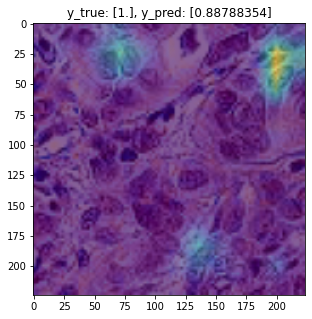

In [43]:
# HISTOPATHOLOGY
plt.rcParams['figure.figsize']=(5,5)
idx=24
hmap = grad_cam(vgg_histo_model, np.expand_dims(x[idx], 0) , 'block5_conv3', H=224, W=224)
plt.imshow(np.asarray(raw_x[idx], dtype=np.uint8))
plt.imshow(hmap, alpha=0.6)
plt.title('y_true: {}, y_pred: {}'.format(y[idx][0][0], vgg_histo_model.predict(np.expand_dims(x[idx], 0))[0]))

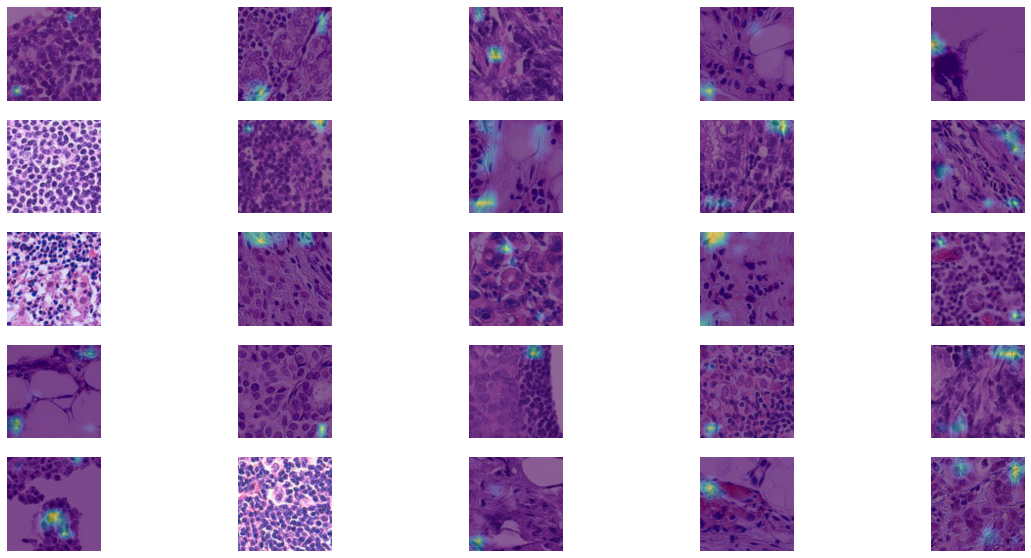

In [42]:
# Let's generate a grid for visual inspection
# Note: there are 64 images in the data sample, so you can generate maximum 
# 8x8 grids
plt.rcParams['figure.figsize']=(20,10)
width=5
height=5
hmap={}
for idx in range(width*height):
  hmap[idx] = grad_cam(vgg_histo_model, np.expand_dims(x[idx], 0) , 'block5_conv3', H=224, W=224)
for idx in range(width*height):
  fig = plt.subplot(width,height,idx+1)
  plt.imshow(np.asarray(raw_x[idx], dtype=np.uint8))
  plt.imshow(hmap[idx], alpha=0.6)
  plt.axis('off')

## Final Remarks and Notes

- Easy-to-apply and intuitive  (+)
- Computationally cheap --> very quick (+)
- Provides a visual feedback directly on the images (+)
- High risk of confirmation bias (-)
    - it only shows where the network activations are the highest, not why or what actually in these areas is a significant factor 
- Visual inspection only may be misleading (-)
- The normalization in the [0,1] range forces the heatmap to have a maximum (-)
- Strong dependence on the effective receptive field (-)
    - the deeper the network, the more diffused the heatmaps

## Best Practices

- Visualize also non-normalized heatmaps
- Perform quantitative analyses to evaluate what the heatmap show on the entire dataset. See [Graziani et al., 2021](https://www.researchgate.net/profile/Mara-Graziani/publication/346789880_Evaluation_and_Comparison_of_CNN_Visual_Explanations_for_Histopathology/links/5fd0d47da6fdcc697bf000cf/Evaluation-and-Comparison-of-CNN-Visual-Explanations-for-Histopathology.pdf)


### Extend the experiments in this notebook

- To work on the full patch camelyon validation data run the cell below



In [ ]:
!wget https://zenodo.org/record/4669282/files/camelyonpatch_level_2_split_valid_y.h5.gz
!mv camelyonpatch_level_2_split_valid_y.h5.gz /content/drive/MyDrive/CNNinterpret/
!gunzip /content/drive/MyDrive/CNNinterpret/camelyonpatch_level_2_split_valid_y.h5.gz
!wget https://zenodo.org/record/2546921/files/camelyonpatch_level_2_split_valid_x.h5.gz
!mv camelyonpatch_level_2_split_valid_x.h5.gz /content/drive/MyDrive/CNNinterpret/
!gunzip /content/drive/MyDrive/CNNinterpret/camelyonpatch_level_2_split_valid_x.h5.gz

- To replicate the staining normalization you can use the cell below

In [ ]:
!wget https://zenodo.org/record/4669282/files/normalizers.py
!mv normalizers.py /content/drive/MyDrive/CNNinterpret/
!wget https://zenodo.org/record/4669282/files/normalizing_patch.npy
!mv normalizing_patch.npy /content/drive/MyDrive/CNNinterpret/
sys.path.append('/content/drive/MyDrive/CNNinterpret/')
from normalizers import *
# STAIN NORMALIZATION FUNCTIONS
def get_normalizer(patch, save_folder=''):
    normalizer = ReinhardNormalizer()
    normalizer.fit(patch)
    np.save('{}/normalizer'.format(save_folder),normalizer)
    np.save('{}/normalizing_patch'.format(save_folder), patch)
    print('Normalisers saved to disk.')
    return normalizer

def normalize_patch(patch, normalizer):
    return np.float64(normalizer.transform(np.uint8(patch)))
normalizer=get_normalizer(np.load('/content/drive/MyDrive/CNNinterpret/normalizing_patch.npy'))